# Text-to-Image and Image-to-image search Using CLIP & PINECONE

In [1]:
import time
start = time.time()

# Import libraries

In [2]:
import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pinecone
from dotenv import load_dotenv

load_dotenv()


c:\Users\jayit\Image-Search\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

# Image Exploration

## Load Data

In [3]:
# https://huggingface.co/datasets/ashraq/fashion-product-images-small
image_data = load_dataset(
    "ashraq/fashion-product-images-small", split="train",
    )

In [4]:
image_data

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [5]:
image_data_df = pd.DataFrame(image_data[:100])

In [6]:
image_data_df.shape

(100, 11)

In [7]:
image_data_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...


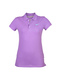

In [8]:
image_data_df.iloc[56]["image"]

In [9]:
def get_model_info(model_ID, device):

  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)

  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # Return model, processor & tokenizer
  return model, processor, tokenizer

In [10]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)

# Create Embeddings: Text and Image Embeddings

## Text Embeddings

In [11]:
def get_single_text_embedding(text):

  inputs = tokenizer(text, return_tensors = "pt").to(device)

  text_embeddings = model.get_text_features(**inputs)

  # convert the embeddings to numpy array
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return embedding_as_np

## Image Embeddings

In [12]:
def get_single_image_embedding(my_image):

  image = processor(
      text = None,
      images = my_image,
      return_tensors="pt"
  )["pixel_values"].to(device)

  embedding = model.get_image_features(image)

  # convert the embeddings to numpy array
  embedding_as_np = embedding.cpu().detach().numpy()

  return embedding_as_np

In [13]:
image_data_df.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
      dtype='object')

## Configure the Pinecone Client

In [14]:
PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
PINECONE_ENV = os.getenv('PINECONE_ENV')

pinecone.init(
    api_key = PINECONE_API_KEY,
    environment = PINECONE_ENV
)

my_index_name = "clip-image-search"

# Connect to the index
my_index = pinecone.Index(my_index_name)

In [15]:
my_index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 100}},
 'total_vector_count': 100}

# Start the query

### Text to image

In [16]:
text_query = image_data_df.iloc[10].productDisplayName
text_query

'Puma Men Future Cat Remix SF Black Casual Shoes'

In [40]:
text_query = 'Pink Shirt'

In [41]:
# Get the caption embedding
query_embedding = get_single_text_embedding(text_query).tolist()

In [42]:
# Run the query
k = 5
res = my_index.query(query_embedding, top_k=k, include_metadata=True)

0.255426884
{'ID': 82.0, 'caption': 'United Colors of Benetton Men Solid Pink Polo T-shirts'}


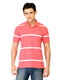

0.240150318
{'ID': 89.0, 'caption': 'Tonga Women Maroon Top'}


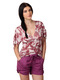

0.235614151
{'ID': 39.0, 'caption': "Jealous 21 Women's Pink T-shirt"}


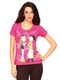

0.230635121
{'ID': 48.0, 'caption': 'John Miller Men Stripes White Red Shirts'}


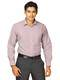

0.230244145
{'ID': 32.0, 'caption': 'John Players Men Brown Shirt'}


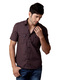

In [43]:
for i in range(k):
    idx = int(res.matches[i].id)
    img = image_data_df.iloc[idx].image
    print(res.matches[i].score)
    print(res.matches[i].metadata)
    display(img)

### Image to image

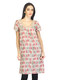

In [20]:
image_query = image_data_df.iloc[43].image
image_query

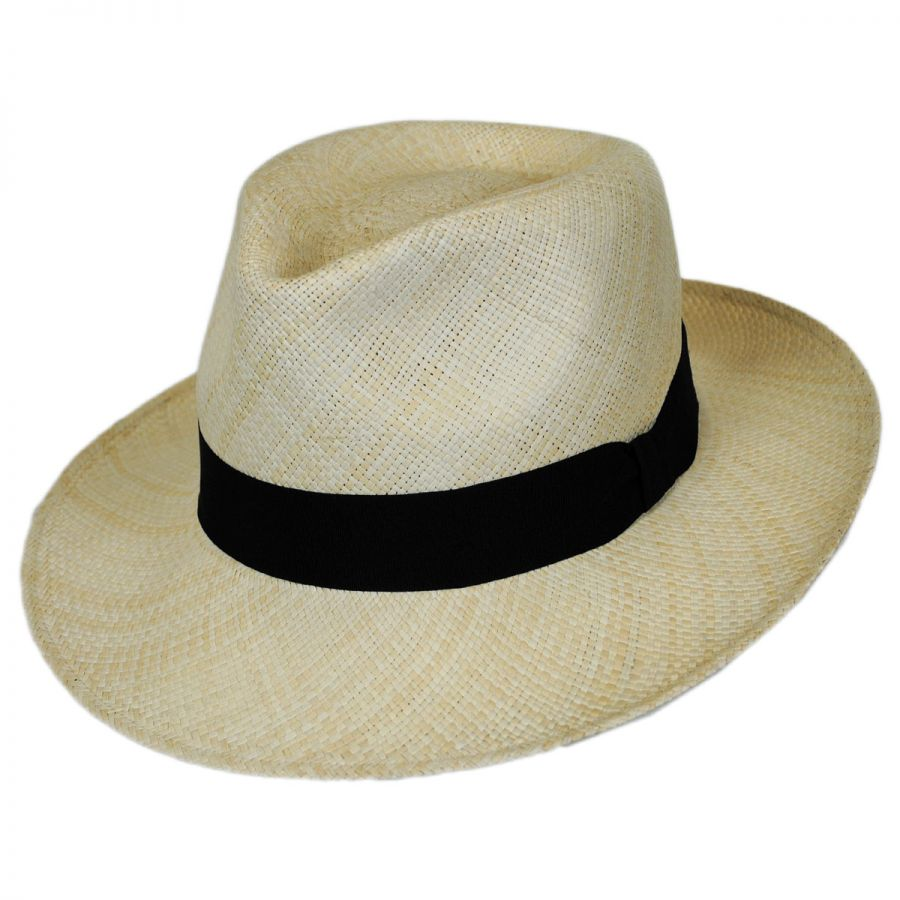

In [25]:
# open method used to open different extension image file
image_query = Image.open(r"size-m.jpg") 
image_query

In [26]:
# Get the text embedding
query_embedding = get_single_image_embedding(image_query).tolist()

In [27]:
# Run the query
k = 5
ans = my_index.query(query_embedding, top_k=k, include_metadata=True)
ans

{'matches': [{'id': '81',
              'metadata': {'ID': 81.0,
                           'caption': 'Lotto Men XL Water Man Silver Slippers'},
              'score': 0.732095659,
              'values': []},
             {'id': '80',
              'metadata': {'ID': 80.0, 'caption': 'Image Men Sunglasses'},
              'score': 0.718518615,
              'values': []},
             {'id': '8',
              'metadata': {'ID': 8.0, 'caption': 'Puma Men Pack of 3 Socks'},
              'score': 0.71701616,
              'values': []},
             {'id': '90',
              'metadata': {'ID': 90.0, 'caption': 'Femella Women Brown Scarf'},
              'score': 0.714793861,
              'values': []},
             {'id': '11',
              'metadata': {'ID': 11.0,
                           'caption': 'Fossil Women Black Huarache Weave Belt'},
              'score': 0.709895313,
              'values': []}],
 'namespace': ''}

id                     19123
gender                   Men
masterCategory      Footwear
subCategory       Flip Flops
articleType       Flip Flops
baseColour            Silver
season                  Fall
year                  2011.0
usage                 Casual
Name: 81, dtype: object
score:  0.732095659
caption:  Lotto Men XL Water Man Silver Slippers


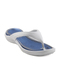

id                      16957
gender                    Men
masterCategory    Accessories
subCategory           Eyewear
articleType        Sunglasses
baseColour              Black
season                 Winter
year                   2016.0
usage                  Casual
Name: 80, dtype: object
score:  0.718518615
caption:  Image Men Sunglasses


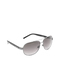

id                      29114
gender                    Men
masterCategory    Accessories
subCategory             Socks
articleType             Socks
baseColour          Navy Blue
season                 Summer
year                   2012.0
usage                  Casual
Name: 8, dtype: object
score:  0.71701616
caption:  Puma Men Pack of 3 Socks


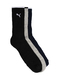

id                      25947
gender                  Women
masterCategory    Accessories
subCategory           Scarves
articleType           Scarves
baseColour              Brown
season                 Summer
year                   2012.0
usage                  Casual
Name: 90, dtype: object
score:  0.714793861
caption:  Femella Women Brown Scarf


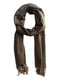

id                      48123
gender                  Women
masterCategory    Accessories
subCategory             Belts
articleType             Belts
baseColour              Black
season                 Summer
year                   2012.0
usage                  Casual
Name: 11, dtype: object
score:  0.709895313
caption:  Fossil Women Black Huarache Weave Belt


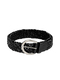

In [39]:
for i in range(k):
    idx = int(ans.matches[i].id)
    img = image_data_df.iloc[idx].image
    attr = image_data_df.iloc[idx][:-2]
    print(attr)
    print("score: ", ans.matches[i].score)
    print("caption: ",ans.matches[i].metadata['caption'])
    display(img)

---

In [24]:
end = time.time()
total_time = end - start
total_time

26.18951416015625